<a href="https://colab.research.google.com/github/Viny2030/NLP/blob/main/23_Ejercicio4_Topic_Modeling_Noticias_BBC_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 23 - Ejercicio: Topic Modeling - Noticias BBC News


* En el siguiente ejercicio tiene como objetivo aplicar los conocimientos adquiridos de ***Topic Modeling***, utilizando el LDA.


* Para ello vamos a trabajar con unos ***artículos de noticias publicados por la BBC*** que los tienen categorizados en 5 temas (Topics)

    - Business
    - Entertainment
    - Politics
    - Sport
    - Tech


* El objetivo de este ejercicio es el de ***obtener un número de temas (Topics) adecuados según los artículos y ver las relaciones entre los temas (Topics) y las palabras (Terms) que caracterizan a los temas (Topics)***.


* Pasos a realizar en el ejercicio:

    1. Carga de datos
    2. Normalizar los textos
    3. Creacción del diccionario y la bolsa de palabras
    4. Selección del número óptimo de Topics
    5. Creacción del Modelo
    6. Visualización

<hr>


## Carga de Datos


* El fichero en formato csv contiene una serie de noticias en los que le asigna una temática.


* Cada elemento del Json contiene:
    - **news**: Contenido del artículo
    - **type**: Temática
    
    
* Leemos los datos y mostramos una muestra:

In [14]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

file = 'https://raw.githubusercontent.com/Viny2030/datasets/refs/heads/main/BBC_News.csv'
df = pd.read_csv(file, encoding="iso-8859-1")
documents = [str(x.encode('utf8')) for x in df.news.values] # Lista de documentos
df.sample(5)

,news,type
811,Hollywood hunts hits at Sundance\n \n The Sund...,entertainment
1490,Ireland v USA (Sat)\n \n Saturday 20 November\...,sport
1046,'Super union' merger plan touted\n \n Two of B...,politics
1225,Gurkhas to help tsunami victims\n \n Britain h...,politics
1472,Wilkinson to miss Ireland match\n \n England w...,sport


* Vemos los 5 tipos de artículos

In [15]:
df.groupby(['type']).count()

,news
type,
business,510
entertainment,386
politics,417
sport,511
tech,401


<hr>


## Normalizar los textos


In [23]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [27]:
import spacy
nlp = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()

# Iterate through the 'news' column of the DataFrame and process each news article individually
for news in df['news']:
    doc = nlp(news)  # Pass the 'news' string to nlp, not the entire DataFrame
    # Process the 'doc' object for each news article here, e.g.,
    # for token in doc:
    #     print(token.text, token.pos_)

In [29]:
from tqdm import tqdm

# Restart the runtime after installing the model. This ensures that the model is loaded correctly into the environment.
# If you are using a notebook, go to the "Runtime" menu and select "Restart runtime".
# After restarting, run the following lines:
nlp = spacy.load("en_core_web_sm")

def normalize(doc, min_words=3):
    """
    Función que dada una lista de tweets, normaliza los tweets y devuelve una lista con los tweets normalizados,
    descartando aquellos tweets que tras la normalización tengan menos de "min_words" palabras en el tweet.

    :param tweets:       Lista de Tweets con el tweet y la clase a la que pertenece
    :param min_words:    Número minimo de palabras que tiene que tener un tweet tras la normalización
    :return:             Lista de Tweets normalizados
    """
    news_list = []
    for news in tqdm(df['news']): # Iterate over the 'news' column of the DataFrame
        # Tokenizamos el tweets realizando los puntos 1,2 y 3.
        tw = nlp(news.lower().replace('.', ' ').replace('#', ' ').strip()) # Use news instead of df[0]

        # Normalizamos Puntos 4,5,6,7 y 8
        tw = ([word.lemma_ for word in tw if (not word.is_punct)
               and (len(word.text) > 2) and (not word.is_stop)
               and (not word.text.startswith('@'))
               and (not word.text.startswith('http'))
               and (not ':' in word.text)])

        # Eliminamos los tweets que tras la normalización tengan menos de "min_words" palabras
        if len(tw) >= min_words:
            news_list.append(tw)
    return news_list

# Normalizamos las frases
X_norm = normalize(doc)

100%|██████████| 2225/2225 [03:13<00:00, 11.53it/s]


<hr>


## Creacción del diccionario y la bolsa de palabras


In [30]:
from pprint import pprint
from gensim import corpora
from collections import defaultdict

# Creamos el diccionario (vocabulario)
frequency = defaultdict(int)
for doc in X_norm:
    for token in doc:
        frequency[token] += 1

documents = [[token for token in doc] for doc in X_norm]
dictionary = corpora.Dictionary(documents)
print('Diccionario:\n{}'.format(dictionary))


# Creamos la Bolsa de Palabras
corpus = [dictionary.doc2bow(doc) for doc in documents]
print('\nPrimer Documento del Corpus:\n{}'.format(corpus[0]))

Diccionario:
Dictionary<23676 unique tokens: ['\n \n ', '27bn', '2bn', '3bn', '6bn']...>

Primer Documento del Corpus:
[(0, 6), (1, 1), (2, 1), (3, 1), (4, 3), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 6), (23, 4), (24, 1), (25, 1), (26, 5), (27, 2), (28, 1), (29, 1), (30, 3), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 6), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 3), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 5), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 4), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 8), (93, 1), (94, 1), (95, 1), (96, 2), (97, 2), (98, 1),

<hr>


## Selección del número óptimo de Topics

In [31]:
from gensim.models import LdaModel, CoherenceModel
from tqdm import tqdm

coherence = []
min_topics = 2
max_topics = 11
for num_topics in tqdm(range(min_topics, max_topics, 1)):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=0,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    coherencemodel = CoherenceModel(model=lda_model, texts=X_norm, dictionary=dictionary, coherence='u_mass')
    coherence.append(coherencemodel.get_coherence())

index = ["Num Topics: {num}".format(num=num) for num in range(min_topics, max_topics, 1)]
pd.DataFrame(coherence, index=index, columns=['Coherence'])

100%|██████████| 9/9 [02:45<00:00, 18.34s/it]


,Coherence
Num Topics: 2,-1.340010
Num Topics: 3,-1.494955
Num Topics: 4,-1.567195
Num Topics: 5,-1.517037
Num Topics: 6,-2.141704
Num Topics: 7,-2.880293
Num Topics: 8,-3.735002
Num Topics: 9,-4.454879
Num Topics: 10,-5.817788


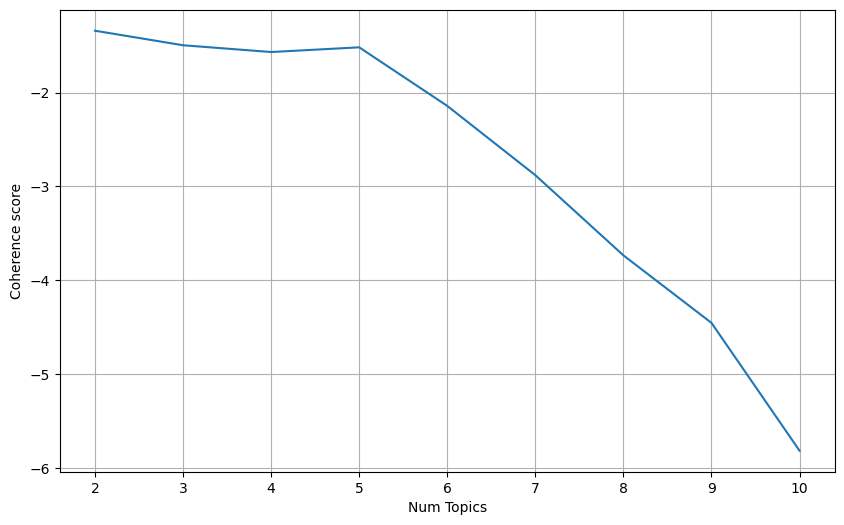

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,6))
plt.plot(range(min_topics, max_topics, 1), coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.grid()
plt.show()

<hr>


## Creacción del Modelo


In [33]:
from gensim.models import LdaModel

lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=0)

<hr>


## Visualización

In [34]:

!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.5 MB/s eta 0:00:00


In [35]:
import pyLDAvis
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)